# XGBoost vs LightGBM

In this notebook we collect the results from all the experiments and reports the comparative difference between XGBoost and LightGBM

In [1]:
import matplotlib.pyplot as plt
import nbformat
import json
from toolz import pipe, juxt
import pandas as pd
import seaborn
from toolz import curry

from bokeh.io import show, output_notebook
from bokeh.charts import Bar
from bokeh.models.renderers import GlyphRenderer
from bokeh.models.glyphs import Rect
from bokeh.models import Range1d
from toolz import curry
from bokeh.io import export_svgs
from IPython.display import SVG, display

%matplotlib inline 

/anaconda/envs/strata/lib/python3.5/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)


In [2]:
output_notebook()

Loading BokehJS ...

We are going to read the results from the following notebooks

In [12]:
notebooks = {
    'Airline':'01_airline.ipynb',
    'Airline_GPU': '01_airline_GPU.ipynb',
    'BCI': '02_BCI.ipynb',
    'BCI_GPU': '02_BCI_GPU.ipynb',
    'Football': '03_football.ipynb',
    'Football_GPU': '03_football_GPU.ipynb',
    'Planet': '04_PlanetKaggle.ipynb',
    'Plannet_GPU': '04_PlanetKaggle_GPU.ipynb',
    'Fraud': '05_FraudDetection.ipynb',
    'Fraud_GPU': '05_FraudDetection_GPU.ipynb',
    'HIGGS': '06_HIGGS.ipynb',
    'HIGGS_GPU': '06_HIGGS_GPU.ipynb'
}

In [13]:
def read_notebook(notebook_name):
    with open(notebook_name) as f:
        return nbformat.read(f, as_version=4)

In [14]:
def results_cell_from(nb):
    for cell in nb.cells:
        if cell['cell_type']=='code' and cell['source'].startswith('# Results'):
            return cell

In [7]:
def extract_text(cell):
    return cell['outputs'][0]['text']

In [8]:
@curry
def remove_line_with(match_str, json_string):
    return '\n'.join(filter(lambda x: match_str not in x, json_string.split('\n')))

In [9]:
def process_nb(notebook_name):
    return pipe(notebook_name,
                read_notebook,
                results_cell_from,
                extract_text,
                remove_line_with('total RAM usage'),
                json.loads)

Here we collect the results from all the exeperiment notebooks. The method simply searches the notebooks for a cell that starts with # Results. It then reads that cells output in as JSON.

In [15]:
results = {nb_key:process_nb(nb_name) for nb_key, nb_name in notebooks.items()}

In [16]:
results

{'Airline': {'lgbm': {'performance': {'AUC': 0.8085689434502803,
    'Accuracy': 0.7353896817753379,
    'F1': 0.6940196231335755,
    'Precision': 0.7695546060118544,
    'Recall': 0.6319874302870966},
   'test_time': 14.591926063993014,
   'train_time': 366.37647559295874},
  'xgb': {'performance': {'AUC': 0.7864092771976574,
    'Accuracy': 0.630096137083639,
    'F1': 0.6981365687005567,
    'Precision': 0.5699044513344648,
    'Recall': 0.9008287536758128},
   'test_time': 12.680251265061088,
   'train_time': 2180.798558813054},
  'xgb_hist': {'performance': {'AUC': 0.8076206419213058,
    'Accuracy': 0.6736735917278169,
    'F1': 0.7170332167054881,
    'Precision': 0.6094592088790932,
    'Recall': 0.8707220218423469},
   'test_time': 14.63406790792942,
   'train_time': 578.727180639049}},
 'Airline_GPU': {'lgbm': {'performance': {'AUC': 0.8337768089671014,
    'Accuracy': 0.759485,
    'F1': 0.7287511489294516,
    'Precision': 0.7825276109281147,
    'Recall': 0.68189061131454

We wish to compare LightGBM and XGBoost both in terms of performance as well as how long they took to train.

In [23]:
def average_performance_diff(dataset):
    lgbm_series = pd.Series(dataset['lgbm']['performance'])
    try:
        perf = 100*((lgbm_series-pd.Series(dataset['xgb']['performance']))/lgbm_series).mean()
    except KeyError:
        perf = None
    return perf

In [25]:
def train_time_ratio(dataset):
    try: 
        perf = dataset['xgb']['train_time']/dataset['lgbm']['train_time']
    except KeyError:
        perf = None
    return perf

def train_time_ratio_hist(dataset):
    try: 
        perf = dataset['xgb_hist']['train_time']/dataset['lgbm']['train_time']
    except KeyError:
        perf = None
    return perf

def test_time_ratio(dataset):
    try: 
        perf = dataset['xgb']['test_time']/dataset['lgbm']['test_time']
    except KeyError:
        perf = None
    return perf

In [26]:
metrics = juxt(average_performance_diff, train_time_ratio, train_time_ratio_hist, test_time_ratio)
res_per_dataset = {dataset_key:metrics(dataset) for dataset_key, dataset in results.items()}

In [27]:
results_df = pd.DataFrame(res_per_dataset, index=['Perf. Difference(%)', 
                                                  'Train Time Ratio',
                                                  'Train Time Ratio Hist',
                                                  'Test Time Ratio']).T

In [28]:
results_df

,Perf. Difference(%),Train Time Ratio,Train Time Ratio Hist,Test Time Ratio
Airline,-0.025994,5.952343,1.579597,0.868991
Airline_GPU,0.930449,3.045320,1.271517,0.402712
BCI,6.250871,2.503829,8.258792,0.711396
BCI_GPU,14.284971,4.676180,15.437377,0.649916
Football,-0.589916,3.909239,4.250369,0.983060
Football_GPU,0.157673,7.268249,4.697221,0.223588
Fraud,-1.076624,6.045945,1.635686,1.060074
Fraud_GPU,-0.780054,19.746408,5.587415,0.922902
HIGGS,0.912015,4.353240,1.318581,0.835345
HIGGS_GPU,NaN,NaN,1.417960,NaN


In [33]:
results_gpu = results_df[[col for col in results_df.columns if col.find('GPU')]]
results_cpu = results_df[~results_df.index.isin(results_gpu)]

In [36]:
results_df.index

Index(['Airline', 'Airline_GPU', 'BCI', 'BCI_GPU', 'Football', 'Football_GPU',
       'Fraud', 'Fraud_GPU', 'HIGGS', 'HIGGS_GPU', 'Planet', 'Plannet_GPU'],
      dtype='object')

In [35]:
[col for col in results_df.columns if col.find('GPU')]

['Perf. Difference(%)',
 'Train Time Ratio',
 'Train Time Ratio Hist',
 'Test Time Ratio']

Plot of train time ratio for CPU experiments.

In [17]:
data = {
    'Ratio': results_cpu['Train Time Ratio'].values.tolist() + results_cpu['Train Time Ratio Hist'].values.tolist(),
    'label': results_cpu.index.values.tolist()*2,
    'group': ['xgb/lgb']*len(results_cpu.index.values) + ['xgb_hist/lgb']*len(results_cpu.index.values)
}

In [18]:
bar = Bar(data, values='Ratio', agg='mean', label='label', group='group', 
          plot_width=600, plot_height=400, bar_width=0.7, color=['#5975a4','#99ccff'], legend='top_right')
bar.axis[0].axis_label=''
bar.axis[1].axis_label='Train Time Ratio (XGBoost/LightGBM)'
bar.axis[1].axis_label_text_font_size='12pt'
bar.y_range = Range1d(0, 30)
bar.toolbar_location='above'
bar.legend[0].visible=True
show(bar)

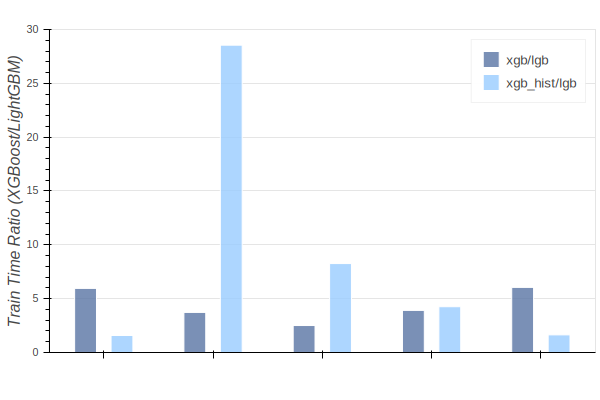

In [19]:
bar.output_backend = "svg"
export_svgs(bar, filename="xgb_vs_lgbm_train_time.svg")
display(SVG('xgb_vs_lgbm_train_time.svg'))

Plot of train time ratio for GPU experiments.

In [27]:
data = {
    'Ratio': results_gpu['Train Time Ratio'].values.tolist() + results_gpu['Train Time Ratio Hist'].values.tolist(),
    'label': results_gpu.index.values.tolist()*2,
    'group': ['xgb/lgb']*len(results_gpu.index.values) + ['xgb_hist/lgb']*len(results_gpu.index.values)
}

In [30]:
bar = Bar(data, values='Ratio', agg='mean', label='label', group='group', 
          plot_width=300, plot_height=400, bar_width=0.5, color=['#ff8533','#ffd1b3'], legend='top_right')
bar.axis[0].axis_label=''
bar.y_range = Range1d(0, 30)
bar.axis[1].axis_label='Train Time Ratio (XGBoost/LightGBM)'
bar.axis[1].axis_label_text_font_size='12pt'
bar.toolbar_location='above'
bar.legend[0].visible=True
show(bar)

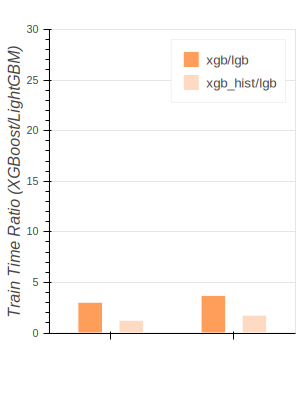

In [31]:
bar.output_backend = "svg"
export_svgs(bar, filename="xgb_vs_lgbm_train_time_gpu.svg")
display(SVG('xgb_vs_lgbm_train_time_gpu.svg'))

In [23]:
data = {
    'Perf. Difference(%)': results_df['Perf. Difference(%)'].values,
    'label': results_df.index.values
}

In [24]:
bar = Bar(data, values='Perf. Difference(%)', agg='mean', label=['label'], 
          plot_width=600, plot_height=400, bar_width=0.7, color='#5975a4')
bar.axis[0].axis_label=''
bar.axis[1].axis_label='Perf. Difference(%)'
bar.toolbar_location='above'
bar.legend[0].visible=False
show(bar)

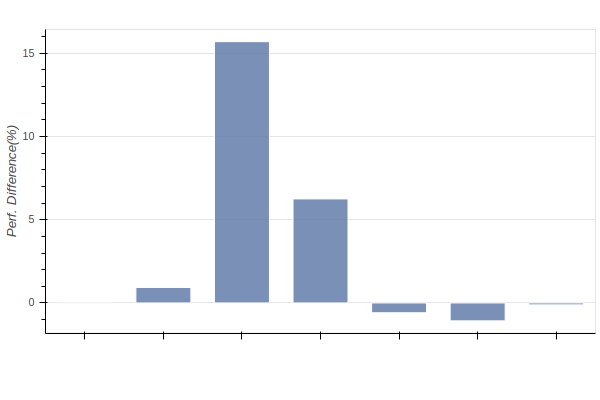

In [25]:
bar.output_backend = "svg"
export_svgs(bar, filename="xgb_vs_lgbm_performance.svg")
display(SVG('xgb_vs_lgbm_performance.svg'))

From the table as well as the plots below we can see that overall the difference in performance is quite small. LightGBM though is 2 to over 10 times quicker than XGBoost.